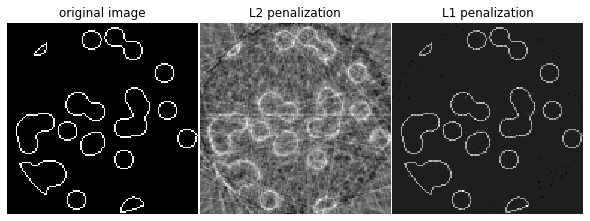

In [3]:
# Author: Emmanuelle Gouillart <emmanuelle.gouillart@nsup.org>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage, sparse

from sklearn.linear_model import Lasso, Ridge


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.0
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x**2)
    data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator


def generate_synthetic_data():
    """Synthetic binary data"""
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.0) ** 2 + (y - l / 2.0) ** 2 < (l / 2.0) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))


# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l // 7)
data = generate_synthetic_data()
proj = proj_operator @ data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation="nearest")
plt.axis("off")
plt.title("original image")
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L2 penalization")
plt.axis("off")
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L1 penalization")
plt.axis("off")

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

plt.show()

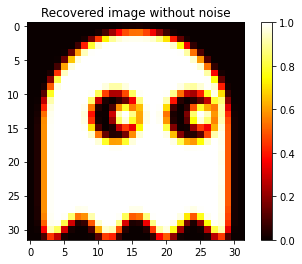

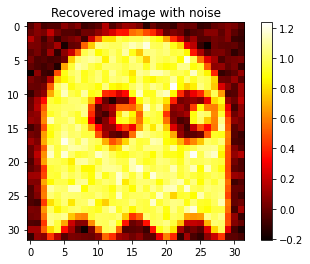

In [1]:
# -*- coding: utf-8 -*-
#%% Demo for single-pixel imaging using Hadamard patterns as sensing basis
# Loads an object, generates the sensing patterns (Hadamard), 
# does the measurements (with and without noise), and recovers the image.

#%% Import libraries
from typing import Tuple
from matplotlib import pyplot as plt
import numpy as np
# Generate hadamard matrices
from scipy.linalg import hadamard
# Working with images
from skimage.transform import resize
from PIL import Image

#%% Define useful functions
def noisify(signal: np.ndarray, end_snr: float) -> bBTuple[np.ndarray, np.ndarray]:
    '''
    Add white gaussian noise to a signal so it ends with end_snr 
    signal-to-noise ratio.
    More info at: https://en.wikipedia.org/wiki/Signal-to-noise_ratio#Decibels
    
    Parameters
    ----------
    signal : np.ndarray
        Input signal
    end_snr : float
        Desired SNR.
    Returns
    -------
    noisy_signal : np.ndarray
        Signal with added noise.
    noise : np.ndarray
        Noise added to the original signal.
    '''
    # Calculate signal average (~power)
    signal_avg = np.mean(signal)
    # Convert to dB
    signal_avg_db = 10 * np.log10(signal_avg)
    # Calculate noise power in dB, using objective SNR
    # SNR = P_signal(in dB) - P_noise(in dB)
    noise_avg_db = signal_avg_db - end_snr
    # Convert to noise average (~power)
    noise_avg = 10**(noise_avg_db/10)
    # Build noise with desired power
    noise = np.random.normal(0, np.sqrt(noise_avg), signal.size)
    # Add noise to signal
    noisy_signal = signal + noise
    
    return noisy_signal, noise

# %%  Load image & generate object
# load image, convert to grayscale, store as array (matrix)
ground_obj = np.asarray(Image.open("./objects/ghost.png").convert('L')) 
# Choose new size (don't go higher than 128x128 or Hadamard will kill you)
px = 32
# Resize image to smaller size for simulation
test_obj = resize(ground_obj,(px,px))

#%% Generate measurement patterns using a Hadamard matrix. 
## Each row is a 2D pattern (after reshaping)
H = hadamard(px**2)   # Complete Hadamard matrix (+1s and -1s)
Hplus = (H + 1) / 2       # H+ Hadamard matrix (1s and 0s)
Hminus = (1 - H) / 2      # H- Hadamard matrix (0s and 1s)

#%% Generate measurements simulating H+ and H- 
#   (as if patterns were generated on a DMD)
Mplus = Hplus @ test_obj.flatten() # Project H+ patterns, store intensity
Mminus = Hminus @ test_obj.flatten() # Project H- patterns, store intensity
M = Mplus - Mminus # Substract values (H+ - H-)

# Generate measurements from a noisy object
desired_SNR = 20 # SNR desired for the object
# Add noise to the true coefficients
Mplus_noisy, _ = noisify(Mplus, desired_SNR) # Project H+
Mminus_noisy, _ = noisify(Mminus, desired_SNR) # Project H-
M_noisy = Mplus_noisy - Mminus_noisy # Substract values (H+ - H-)

#%% Recover objects
# Inversion from measurements (solve the eq. systems with/without noise)
recovery = np.linalg.solve(H, M)
recovery_noise = np.linalg.solve(H, M_noisy)
# Reshape from vector into image
recovery = recovery.reshape((px, px))
recovery_noise = recovery_noise.reshape((px, px))

#%% Show the results
# Show recovery without noise
plt.figure()
plt.imshow(recovery, cmap = 'hot')
plt.axis('on')
plt.title('Recovered image without noise')
plt.colorbar()
plt.show()
# Show recovery with noise
plt.figure()
plt.imshow(recovery_noise, cmap = 'hot')
plt.axis('on')
plt.title('Recovered image with noise')
plt.colorbar()
plt.show()


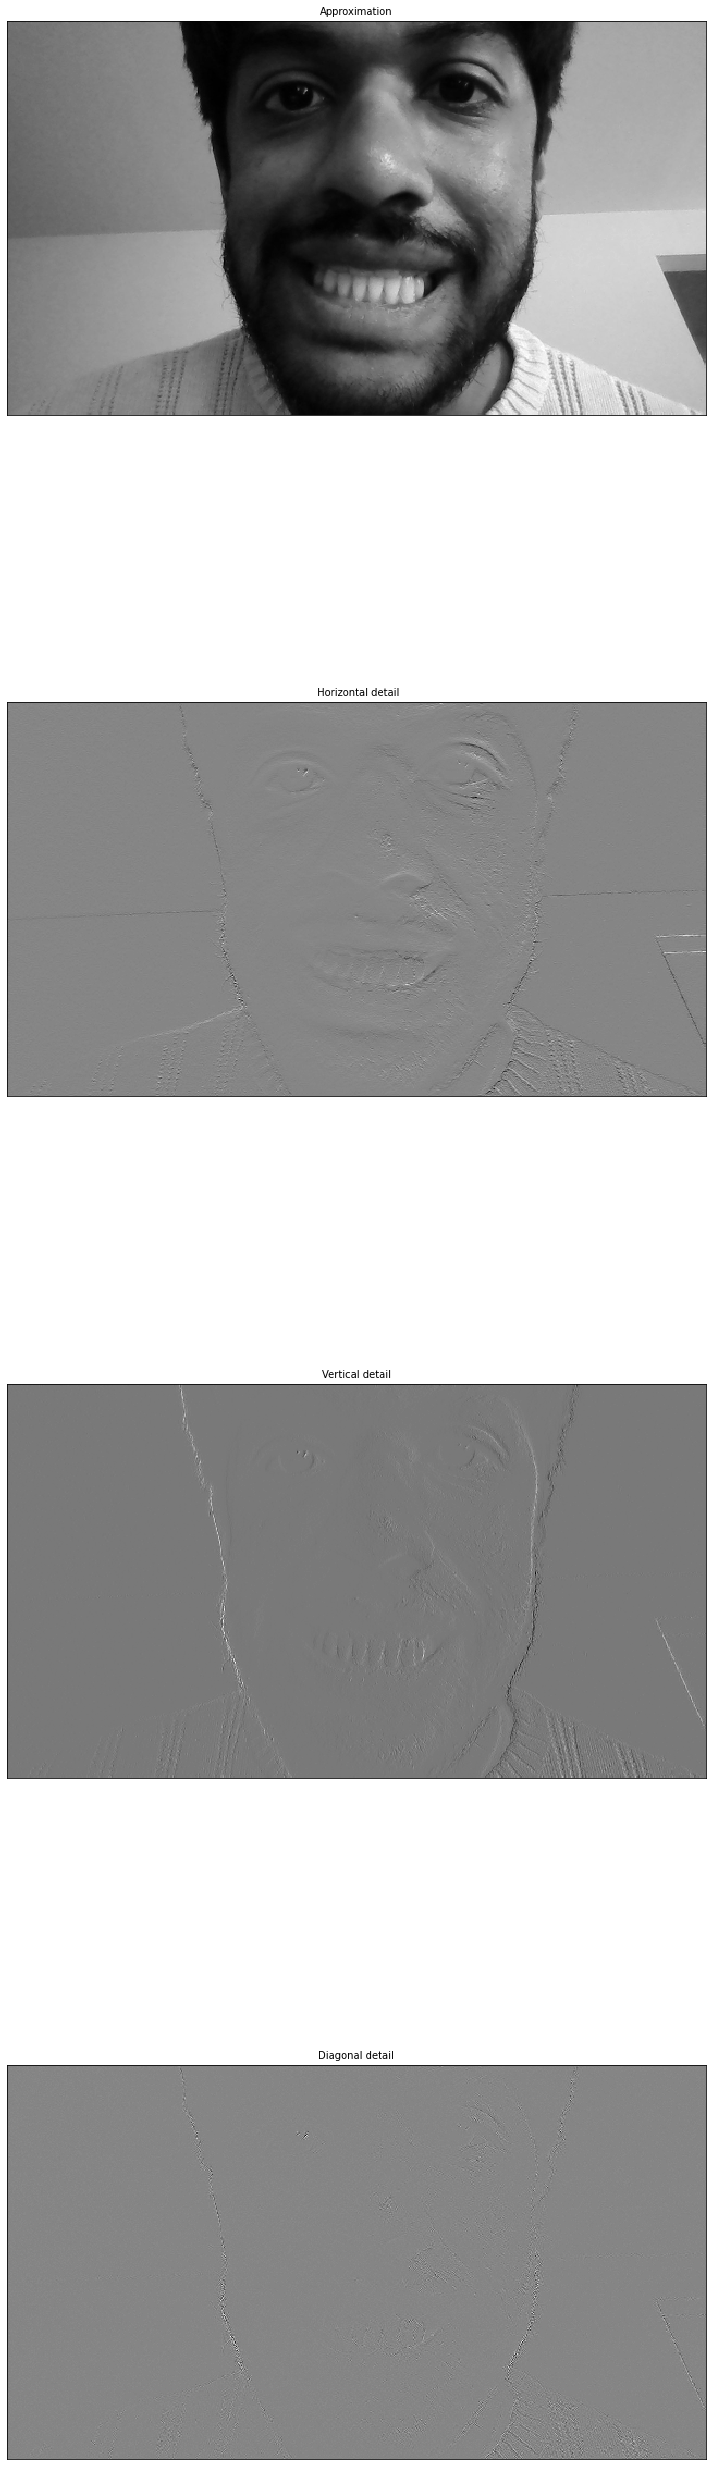

In [4]:
import pywt
import pywt.data
import cv2

#Load image
# original = pywt.data.camera()

image = cv2.imread("image.jpg")
original = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(10, 10*4))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(4, 1, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()


921600


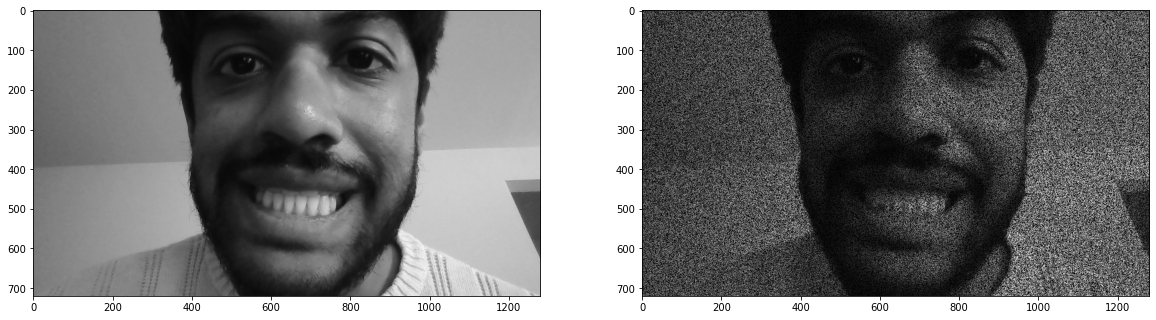

In [6]:
undersample_rate = .5
n = original.shape[0] * original.shape[1]
print(n)
original.reshape(-1)
shape = original.shape
original_undersampled = ( original.reshape(-1) \
    * np.random.permutation( 
        np.concatenate( 
            (np.ones( int( n * undersample_rate ) ), 
             np.zeros( int( n * ( 1-undersample_rate )) )) 
        ) 
    ) 
                        ).reshape(shape)

fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(original, cmap=plt.cm.gray)
ax[1].imshow(original_undersampled,cmap=plt.cm.gray)

In [10]:
def soft_thresh(x, lam):
    if ~(isinstance(x[0], complex)):
        return np.zeros(x.shape) + (x + lam) * (x<-lam) + (x - lam) * (x>lam) 
    else:
        return np.zeros(x.shape) + ( abs(x) - lam ) / abs(x) * x * (abs(x)>lam) 
    
def flat_wavelet_transform2(x, method='bior1.3'):
    """For a 2D image x, take the wavelet """
    coeffs = pywt.wavedec2( x, method )
    output = coeffs[0].reshape(-1)
    for tups in coeffs[1:]:
        for c in tups:
            output = np.concatenate((output, c.reshape(-1)))
    return output

def inverse_flat_wavelet_transform2(X,  shape, method='bior1.3'):
    shapes = pywt.wavedecn_shapes( shape , method)
    nx = shapes[0][0]
    ny = shapes[0][1]
    n = nx * ny
    coeffs = [X[:n].reshape(nx,ny) ]
    for i, d in enumerate(shapes[1:]):
        vals=list(d.values())
        nx = vals[0][0]
        ny = vals[0][1]
        coeffs.append( (X[ n : n + nx * ny].reshape( nx, ny ), 
                        X[ n + nx * ny : n + 2 * nx * ny ].reshape( nx, ny ), 
                        X[ n + 2 * nx * ny : n + 3 * nx * ny ].reshape( nx, ny ))  )
        n += 3 * nx * ny
    return pywt.waverec2(coeffs, method)

def distance(x,y):
    return sum(abs(x.reshape(-1)-y.reshape(-1)))


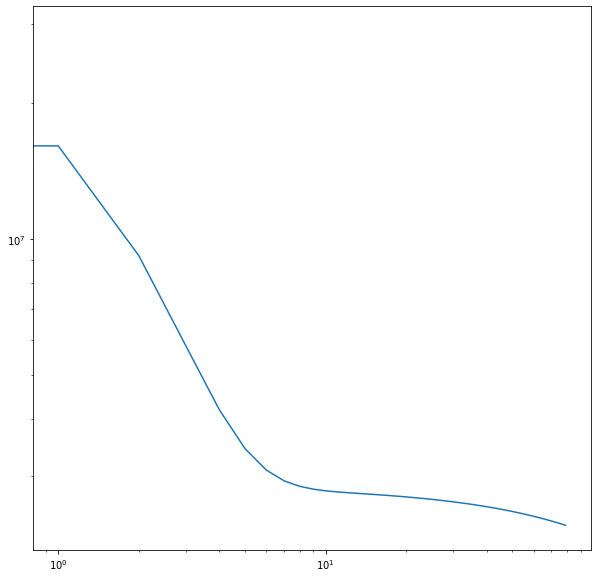

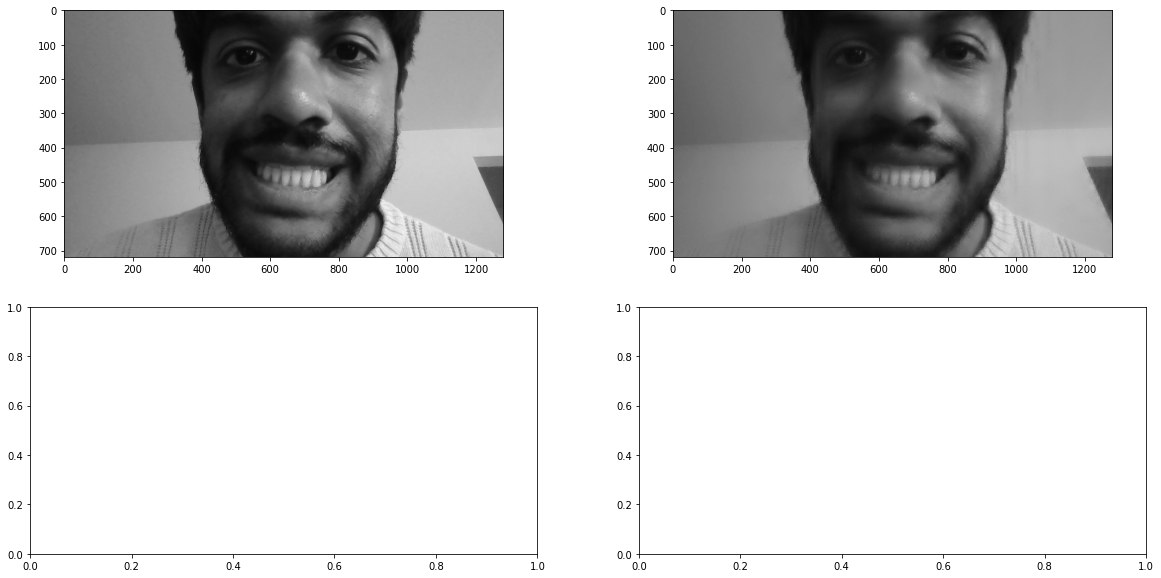

In [12]:
# methods = ['haar','coif1','coif2','coif3','bior1.1','bior1.3','bior3.1','bior3.3','rbio1.1','rbio1.3','rbio3.1','rbio3.3']
# undersampled noisy signal in image-space and let this be first order Xhat
y = original_undersampled

eps = 1e-2
lam = 100
lam_decay = 0.995
# minlam = 1

err2=[]

xhat = y.copy()
for i in range(80):
    method = 'sym3'
    xhat_old = xhat
    Xhat_old = flat_wavelet_transform2(xhat, method)
    Xhat = soft_thresh(Xhat_old, lam)
    xhat = inverse_flat_wavelet_transform2(Xhat, shape, method)
    xhat[y!=0] = y[y!=0]   


    xhat = xhat.astype(int)
    xhat[xhat<0] = 0
    xhat[xhat>255] = 255
    err2.append(distance(original, xhat))
    lam *= lam_decay 

fig = plt.figure(figsize=(10,10))  
plt.loglog(err2)


fig,ax = plt.subplots(2,2,figsize=(20,10))
ax[0][0].imshow(original, cmap=plt.cm.gray)
ax[0][1].imshow(xhat,cmap=plt.cm.gray, vmin=0, vmax=255)

In [ ]:
#Currently have sample 2D -> some space and then reconstruction back some space -> 2D with some basic loss metric
#Want to have something that can detect properties of the image in the space, for example if there are orthogonal lines in a picture can we detect these lines in the space
#Also add better metrics and see if operations are similar